# Dit Sandbox

## VQ-based discrete Transformer tokens

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import einops
from patch_vae import VAE as VqVae

In [2]:
class Image2Token(nn.Module):
    def __init__(self, latent=4, num_codebook=4096):
        super().__init__()
        vqvae = VqVae(latent=latent, num_codebook=num_codebook)
        vqvae.load_state_dict(torch.load('patch_vae.pth'))
        self.vqvae = vqvae
        self.vqvae.requires_grad = False
        self.latent = latent
        
    def forward(self, x):
        p = einops.rearrange(x, 'b c (h p1) (w p2) -> (b h w) c p1 p2', p1 = 4, p2 = 4)
        z = self.vqvae.encoder(p)
        v, _ = self.vqvae.vq(z)
        v = v.reshape(x.shape[0], -1, self.latent)
        return v

In [3]:
image2token = Image2Token()

In [4]:
import torchvision
import tqdm

def get_dataloader():
    tf = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])
    dataset = torchvision.datasets.MNIST(
        "./data",
        train=True,
        download=True,
        transform=tf,
    )
    return torch.utils.data.DataLoader(dataset, batch_size=128, shuffle=True, num_workers=8)

dataloader = get_dataloader()
for batch in dataloader:
    images, _ = batch
    break

In [5]:
t = image2token(images)

In [6]:
print(images.shape, t.shape)

torch.Size([128, 1, 28, 28]) torch.Size([128, 49, 4])


In [7]:
r = torch.rand((128, 1, 28, 28))
rr = image2token(r)

## conv2d-based continues Transformer tokens

In [8]:
class Image2ContinuesToken(nn.Module):
    def __init__(self, embed_dim, patch_size=4, in_channels=1):
        super().__init__()
        self.patches = nn.Conv2d(1, embed_dim, kernel_size=patch_size, stride=patch_size, padding=0, bias=False)
    def forward(self, x):
        x = self.patches(x)
        B, C, H, W = x.shape
        x = x.permute([0, 2, 3, 1]).reshape([B, H * W, C])
        return x

In [9]:
image2token = Image2ContinuesToken(embed_dim=4, patch_size=4)
t = image2token(images)
print(images.shape, t.shape)

torch.Size([128, 1, 28, 28]) torch.Size([128, 49, 4])


In [103]:
class Noiser:
    '''
    Noiser generates the noise. It's the diffusion process.
    Given x0 is the orignal image, it can geneate x1, x2, ..., xt images which has more noise in steps.
    '''
    def __init__(self, device, n_steps=1000, beta_min=0.0001, beta_max=0.02):
        self.device = device
        self.n_steps = 1000
        self.betas = torch.linspace(beta_min, beta_max, n_steps).to(device)
        self.alphas = 1 - self.betas
        self.alpha_bars = torch.tensor([torch.prod(self.alphas[:i + 1]) for i in range(len(self.alphas))]).to(device)

    def noisy(self, x0, t):
        with torch.no_grad():
            n, c, h, w = x0.shape
            alpha_bar = self.alpha_bars[t]
            epislon = torch.randn(n, c, h, w).to(self.device)
            xt = alpha_bar.sqrt().reshape(n, 1, 1, 1) * x0 + (1 - alpha_bar).sqrt().reshape(n, 1, 1, 1) * epislon
            return xt, epislon
        
    def noisy_1d(self, x0, t):
        # TODO: find a way to merge it with noisy to handle different dimentions
        with torch.no_grad():
            n, c = x0.shape
            alpha_bar = self.alpha_bars[t]
            epislon = torch.randn_like(x0).to(self.device)
            xt = alpha_bar.sqrt().reshape(n, 1) * x0 + (1 - alpha_bar).sqrt().reshape(n, 1) * epislon
            return xt, epislon

import math
class TimeEmbedding(nn.Module):
    '''
    Precalculated time embedding, like position encoding.
    '''
    def __init__(self, dim, scale=1.0):
        super().__init__()
        assert dim % 2 == 0
        self.half_dim = dim // 2
        self.seed = math.log(10000) / self.half_dim
        self.scale = scale

    def forward(self, t):
        device = t.device
        x = torch.exp(torch.arange(self.half_dim, device=device) * -self.seed)
        x = torch.outer(t * self.scale, x)
        x = torch.cat((x.sin(), x.cos()), dim=-1)
        return x

class RMSNorm(nn.Module):
    '''
    Root Mean Square Layer Normalization, https://arxiv.org/abs/1910.07467
    Trick: RMSNorm is 15.9/14.17 = 1.12X faster than GPT2 LayerNorm
    '''
    def __init__(self, embed_dim, eps=1e-5):
        super().__init__()
        self.eps = eps
        self.weight = nn.Parameter(torch.ones(embed_dim))

    def forward(self, x: torch.Tensor):
        return self.weight * x * torch.rsqrt(x.pow(2).mean(-1, keepdim=True) + self.eps)
    
class RoPE(nn.Module):
    '''
    Rotary Position Encoding, https://arxiv.org/abs/2104.09864
    Trick: RoPE performance is much better than other position encoding.
    Trick: RoPE once or RoPE in each attention's Q and K has no difference.
    '''
    def __init__(self, max_seq, embed_dim, theta = 10000.0):
        super().__init__()
        self.register_buffer("freqs_complex", self.pre_calc(max_seq, embed_dim, theta))

    def pre_calc(self, max_seq, embed_dim, theta):
        theta_numerator = torch.arange(0, embed_dim, 2)
        theta = 1.0 / (theta ** (theta_numerator / embed_dim))
        position = torch.arange(max_seq)
        freqs = torch.outer(position, theta)
        freqs_complex = torch.polar(torch.ones_like(freqs), freqs)
        freqs_complex = freqs_complex.unsqueeze(0)
        return freqs_complex

    def forward(self, x):
        x_complex = torch.view_as_complex(x.contiguous().reshape(*x.shape[:-1], -1, 2))
        x_rotated = x_complex * self.freqs_complex
        x_out = torch.view_as_real(x_rotated)
        x_out = x_out.reshape(*x.shape)
        return x_out

class GemmaBlock(nn.Module):
    '''
    Gemma Block
    '''
    def __init__(self, embed_dim, num_heads, dropout, max_seq):
        super().__init__()
        self.ln1 = RMSNorm(embed_dim)
        # Trick: when using nn.MultiheadAttention, take care the batch_first and attn_mask
        self.attention = nn.MultiheadAttention(embed_dim=embed_dim, num_heads=num_heads, batch_first=True, dropout=dropout)
        self.register_buffer("attention_mask", torch.tril(torch.ones((max_seq, max_seq))) == 0)
        self.ln2 = RMSNorm(embed_dim)
        self.ff_gate = nn.Linear(embed_dim, 2*embed_dim)
        self.ff_in_proj = nn.Linear(embed_dim, 2*embed_dim)
        self.ff_out_proj = nn.Linear(2*embed_dim, embed_dim)
        self.ff_dropout = nn.Dropout(dropout)
    
    def forward(self, x):
        # Trick: put FF before attention has no difference. Maybe it's too expensive for people to try.
        res = self.ln1(x)
        res, _ = self.attention(res, res, res, attn_mask=self.attention_mask)
        x = x + res
        
        # Trick: Gemma/Llama feed-forward is 14.17/12.8=1.10x faster than GPT2 feed-forward.
        res = self.ln2(x)
        gate = F.gelu(self.ff_gate(res))
        v = self.ff_in_proj(res)
        res = gate * v
        res = self.ff_out_proj(res)
        res = self.ff_dropout(res)
        x = x + res
        return x

class DiT(nn.Module):
    def __init__(self, n_steps, embed_dim, patch_size=4, in_channels=1, n_blocks=1, num_heads=8, dropout=0.1, max_seq=49):
        super().__init__()
        # Diffusion - Time
        self.time_emb = TimeEmbedding(dim=embed_dim)
        # Transformer - Continue Tokenizer
        self.patches = nn.Conv2d(1, embed_dim, kernel_size=patch_size, stride=patch_size, padding=0, bias=False)
        self.decoding = nn.Linear(embed_dim, patch_size * patch_size * in_channels, bias=True)
        self.ps = nn.PixelShuffle(patch_size)
        # Transformer - Position & Block
        self.rope = RoPE(max_seq=max_seq, embed_dim=embed_dim)
        self.blocks = nn.ModuleList()
        for _ in range(n_blocks):
            self.blocks.append(GemmaBlock(embed_dim=embed_dim, num_heads=num_heads, dropout=dropout, max_seq=max_seq))
        
    def forward(self, x, t):
        # Time encoding
        t = self.time_emb(t).unsqueeze(1)
        
        # Patchify and continuse-tokenize
        x = self.patches(x)
        B, C, NPH, NPW = x.shape
        x = x.permute([0, 2, 3, 1]).reshape([B, NPH * NPW, C]) # [B, NPH*NPW, C]
        
        x = x + t
        
        # Transformer
        x = self.rope(x)
        # Blocks
        for block in self.blocks:
            x = block(x)
        
        # Head
        x = self.decoding(x) # [B, NPH*NPW, P*P]
        x = x.permute([0, 2, 1]) # [B, P*P, NPH*NPW]
        x = x.reshape([B, -1, NPH, NPW]) # [B, P*P, NPH, NPW]
        x = self.ps(x) # [B, 1, H, W]
        return x
    
##################################################################################################################################
from torch.utils.tensorboard import SummaryWriter
import torchvision
import tqdm

def get_dataloader(batch_size=128):
    transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])
    dataset = torchvision.datasets.mnist.MNIST("./data", download=True, train=True, transform=transform)
    return torch.utils.data.DataLoader(dataset, batch_size, shuffle=True)

def repeat(objects, times):
    for i in range(times):
        for obj in objects:
            yield obj

def get_device():
    device = 'cpu'
    if torch.backends.mps.is_available():
        device = 'mps:0'
    if torch.cuda.is_available():
        device = 'cuda'
    return device


def train(n_epochs, embed_dim=64, patch_size=4, n_steps=1000, batch_size=128, model_path='dit.pth'):
    device = get_device()
    dataloader = get_dataloader(batch_size=batch_size)
    noiser = Noiser(device=device, n_steps=n_steps)
    net = DiT(embed_dim=embed_dim, patch_size=patch_size, n_steps=n_steps).to(device)
    optim = torch.optim.Adam(net.parameters())
    
    net.train()
    writer = SummaryWriter(comment='-dit')
    for batch_idx, batch in tqdm.tqdm(enumerate(repeat(dataloader, n_epochs)), total=len(dataloader)*n_epochs):
        # generate (xt, epsilon) pair for training, it also can be implemented as torchvision.transforms
        x0 = batch[0].to(device)
        x0_batch = len(x0)
        t = torch.randint(0, n_steps, (x0_batch,)).to(device) # time
        xt, epsilon = noiser.noisy(x0, t)
        epsilon_hat = net(xt, t)
        loss = nn.functional.mse_loss(epsilon_hat, epsilon)
        optim.zero_grad()
        loss.backward()
        optim.step()
        # TensorBoard
        writer.add_scalar("Loss", loss.item(), batch_idx)
    torch.save(net.state_dict(), model_path)

In [104]:
train(n_epochs=3)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1407/1407 [00:45<00:00, 31.25it/s]


In [105]:
import matplotlib.pyplot as plt

def show_images(images):
    # Converting images to CPU numpy arrays
    if type(images) is torch.Tensor:
        images = images.detach().cpu().numpy()

    # Defining number of rows and columns
    fig = plt.figure(figsize=(4, 4))
    rows = int(len(images) ** (1 / 2))
    cols = round(len(images) / rows)

    # Populating figure with sub-plots
    idx = 0
    for r in range(rows):
        for c in range(cols):
            if idx < len(images):
                fig.add_subplot(rows, cols, idx + 1)
                plt.imshow(images[idx][0], cmap="gray")
                plt.axis('off')
                idx += 1
    plt.tight_layout()
    plt.show()

def predict_ddim(embed_dim=64, patch_size=4, ddim_steps=20, eta=1, n_samples=16, c=1, h=28, w=28, n_steps=1000, model_path='dit.pth'):
    device = get_device()
    noiser = Noiser(device=device, n_steps=n_steps)
    net = DiT(embed_dim=embed_dim, patch_size=patch_size, n_steps=n_steps).to(device)
    net.load_state_dict(torch.load(model_path))

    net.eval()
    with torch.no_grad():
        ts = torch.linspace(n_steps, 0, (ddim_steps + 1)).to(torch.long).to(device)
        x = torch.randn(n_samples, c, h, w).to(device)
        for i in tqdm.tqdm(range(ddim_steps)):
            cur_t = ts[i] - 1 # 999
            prev_t = ts[i+1] - 1 # 949
            time_tensor = (torch.ones(n_samples).to(device) * cur_t).long()
            epislon = net(x, time_tensor)
            noise = torch.randn_like(x)

            ab_cur = noiser.alpha_bars[cur_t]
            ab_prev = noiser.alpha_bars[prev_t] if prev_t >= 0 else 1
            var = eta * torch.sqrt((1 - ab_prev) / (1 - ab_cur) * (1 - ab_cur / ab_prev))
            w1 = (ab_prev / ab_cur)**0.5
            w2 = (1 - ab_prev - var**2)**0.5 - (ab_prev * (1 - ab_cur) / ab_cur)**0.5
            w3 = var
            x = w1 * x + w2 * epislon + w3 * noise
    show_images(x)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 266.53it/s]


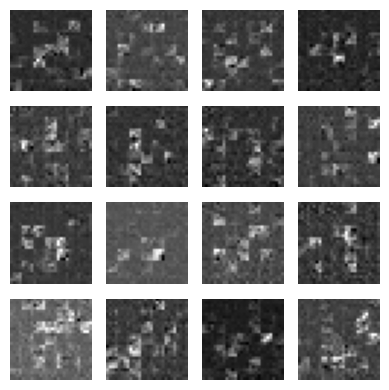

In [106]:
predict_ddim()

In [4]:
class PositionalEmbedding(nn.Module):
    def __init__(self, dim, scale=1.0):
        super().__init__()
        assert dim % 2 == 0
        self.dim = dim
        self.scale = scale

    def forward(self, x):
        device = x.device
        half_dim = self.dim // 2
        emb = math.log(10000) / half_dim
        emb = torch.exp(torch.arange(half_dim, device=device) * -emb)
        emb = torch.outer(x * self.scale, emb)
        emb = torch.cat((emb.sin(), emb.cos()), dim=-1)
        return emb

In [5]:
emb = PositionalEmbedding(64)
scale = nn.Linear(64, 64)

In [7]:
t = torch.randint(0, 1000, (128,))

In [17]:
x = emb(t).unsqueeze(1)